In [1]:
# Standard libraries
import numpy as np
import pandas as pd
from numpy.linalg import multi_dot
from scipy.stats import norm
from scipy.stats import t

# ARIMA libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# ML libraries
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, accuracy_score

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt
# Plot settings
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.linewidth'] = 2.0

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Prix et rendements

L'objectif de cette section est de mesurer votre capacité à:
- Extraire des données, les visualiser, les interpreter
- Maitriser les concepts utilisés
- Construire un modèle prédictif

Le fichier 'Nasdaq.csv' résume les valeurs journalières de l'indice du 5 février 1971 au 19 janvier 2022.

In [2]:
# Load the CSV file
nasdaq = pd.read_csv('Nasdaq.csv', index_col=0, parse_dates=True, dayfirst=True)  
nasdaq

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0
1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0
...,...,...,...,...,...,...
2022-01-12,15263.099610,15319.030270,15117.290040,15188.389650,15188.389650,4321180000
2022-01-13,15245.040040,15259.709960,14782.240230,14806.809570,14806.809570,4283070000
2022-01-14,14708.019530,14897.679690,14689.429690,14893.750000,14893.750000,4345780000


## Visualisation graphique du cours entre 2020 et 2021

Tracez sur un graphique l'évolution du cours du Nasdaq entre 2020 et 2021, en utilisant les prix de fermture ajustés (Adj Close).

Text(0, 0.5, 'Adj Close')

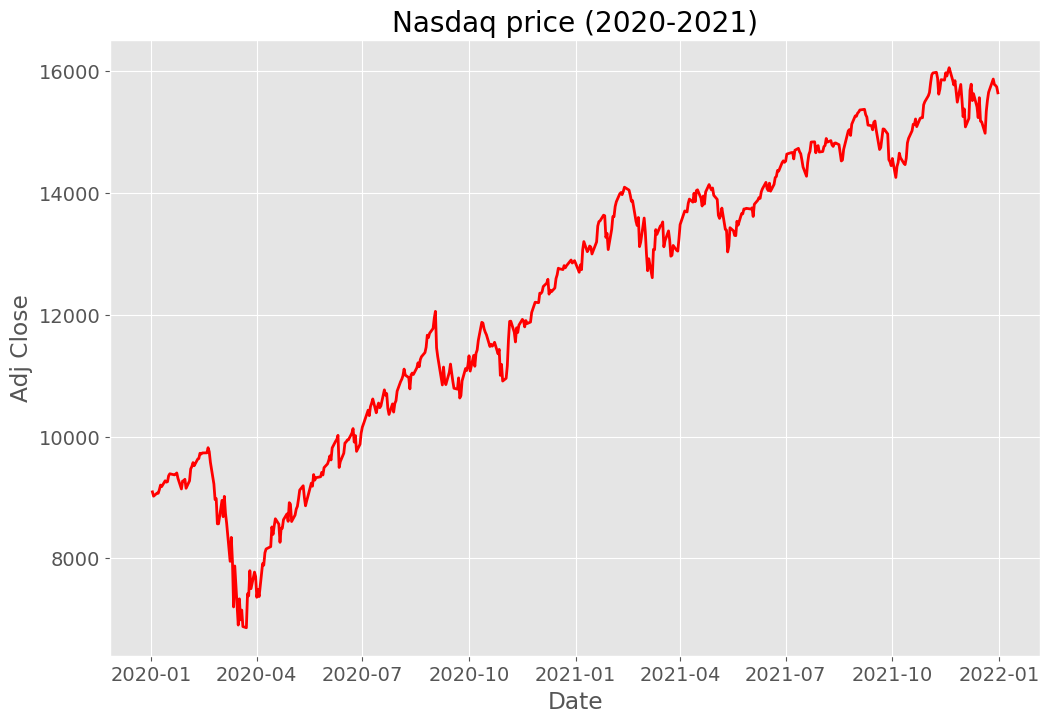

In [3]:
#Convert indexes to datetime type
nasdaq.index = pd.to_datetime(nasdaq.index)
#Filter data for the period 2020 to 2021
nasdaq_2020_2021 = nasdaq['2020':'2021']
#Check for empty values in the time series
empty_test = nasdaq_2020_2021['Adj Close'].isna().any()
if empty_test == True:
    nasdaq_2020_2021 = nasdaq_2020_2021.dropna()
    print("Your time series has empty values. You need to edit or delete them. By default, we delete empty values")
#Visualize the plot
plt.plot(nasdaq_2020_2021.index, nasdaq_2020_2021['Adj Close'], color='red', linewidth=2)
plt.title('Nasdaq price (2020-2021)')
plt.xlabel('Date')
plt.ylabel('Adj Close')

## Rendements et Volatilités historiques

Calculez le rendement journalier moyen du Nasdaq, ainsi que sa volatilité, sur:
- l'ensemble de la période disponible (1971-2022)
- sur la période 2020-2021

In [4]:
# Calculate daily yields
nasdaq['Daily_Return'] = (nasdaq['Adj Close'] - nasdaq['Adj Close'].shift(1)) / nasdaq['Adj Close'].shift(1)
nasdaq = nasdaq.dropna(subset=['Daily_Return'])
# Average daily return and volatility over 1971-2022
total_average_yield = nasdaq['Daily_Return'].mean()
volatility_total = nasdaq['Daily_Return'].std()
# Filter data for the 2020-2021 period
nasdaq_return_2020_2021 = nasdaq['2020-01-01':'2021-12-31']
# Average daily yield and volatility over 2020-2021
average_yield_2020_2021 = nasdaq_return_2020_2021['Daily_Return'].mean()
volatility_2020_2021 = nasdaq_return_2020_2021['Daily_Return'].std()
# Display results
print("Average daily return (1971-2022):", round(total_average_yield*100,2), '%')
print("Volatility (1971-2022):", round(volatility_total*100,2), '%')
print("\nAverage daily return (2020-2021):", round(average_yield_2020_2021*100,2), '%')
print("Volatility (écart-type) (2020-2021):", round(volatility_2020_2021*100,2), '%')

Average daily return (1971-2022): 0.05 %
Volatility (1971-2022): 1.25 %

Average daily return (2020-2021): 0.13 %
Volatility (écart-type) (2020-2021): 1.77 %


Annualisez vos résulats. Commentez

In [5]:
# Annualized results
annualized_total_average_daily_yield = (total_average_yield + 1)**252 - 1
annualized_volatility_total = volatility_total * (252)**0.5
annualized_average_daily_yield_2020_2021 = (average_yield_2020_2021 + 1)**252 - 1
annualized_volatility_2020_2021 = volatility_2020_2021 * (252)**0.5
print("Annualized average daily yield (1971-2022):", round(annualized_total_average_daily_yield*100, 2), "%")
print("Annualized volatility (1971-2022):", round(annualized_volatility_total*100, 2), "%")
print("\nAnnualized average daily yield (2020-2021):", round(annualized_average_daily_yield_2020_2021*100, 2), "%")
print("Annualized volatility (2020-2021):", round(annualized_volatility_2020_2021*100, 2), "%")

#Comments
"""
The price of the nasdaq index was more volatile between 2020 and 2021 than over the entire period. 
This high volatility explains the index's higher profitability between 2020 and 2021 than over the entire period.
Indeed, investing for the short term is riskier than investing for the long term.
Moreover, the 2020-2021 period corresponds to the Covid-19 crisis.
In the first quarter of 2020, the prices of the main stock market indices, such as the Nasdaq, fell sharply, 
but following the economic recovery, they experienced strong average growth over the rest of the period. 
More specifically, the Nasdaq index is dedicated to companies in the technology sector. 
For technology companies, the lock-downs put in place around the world have been highly profitable 
as the increased reliance on technology for work (remote working), communication (social networks),
and entertainment (video games, streamingfueled a surge in demand for their products and services.
"""

Annualized average daily yield (1971-2022): 12.42 %
Annualized volatility (1971-2022): 19.84 %

Annualized average daily yield (2020-2021): 37.34 %
Annualized volatility (2020-2021): 28.14 %


"\nThe price of the nasdaq index was more volatile between 2020 and 2021 than over the entire period. \nThis high volatility explains the index's higher profitability between 2020 and 2021 than over the entire period.\nIndeed, investing for the short term is riskier than investing for the long term.\nMoreover, the 2020-2021 period corresponds to the Covid-19 crisis.\nIn the first quarter of 2020, the prices of the main stock market indices, such as the Nasdaq, fell sharply, \nbut following the economic recovery, they experienced strong average growth over the rest of the period. \nMore specifically, the Nasdaq index is dedicated to companies in the technology sector. \nFor technology companies, the lock-downs put in place around the world have been highly profitable \nas the increased reliance on technology for work (remote working), communication (social networks),\nand entertainment (video games, streamingfueled a surge in demand for their products and services.\n"

## Distribution des rendements - Distibution empirique VS normale

1. Tracez l'histogramme des rendements historiques de 1971 à 2022
2. Completez le graphique avec la distribution normale qui y est associée (paramètres calculés plus haut)
3. Commentez

'\nAs we can see from the graph below, the time series of historical daily returns for the NASDAQ from 1971 to 2022 \nfollows approximately a normal distribution. Indeed, the density function of the time series of nasdaq returns \nlooks like a centred symmetrical bell curve. However, to support our graphical analysis, \nwe can calculate the degree of skewness of this time series, and if the skewness is close to 0, \nwe can state that nasdaq returns from 1971 to 2022 follow a normal distribution.\nWe can also use the Komolgorov-Smirnov test to determine whether our time series follows a normal distribution. \nIf the p-value is greater than 0.05, then we can state that the time series follows a normal distribution. \n'

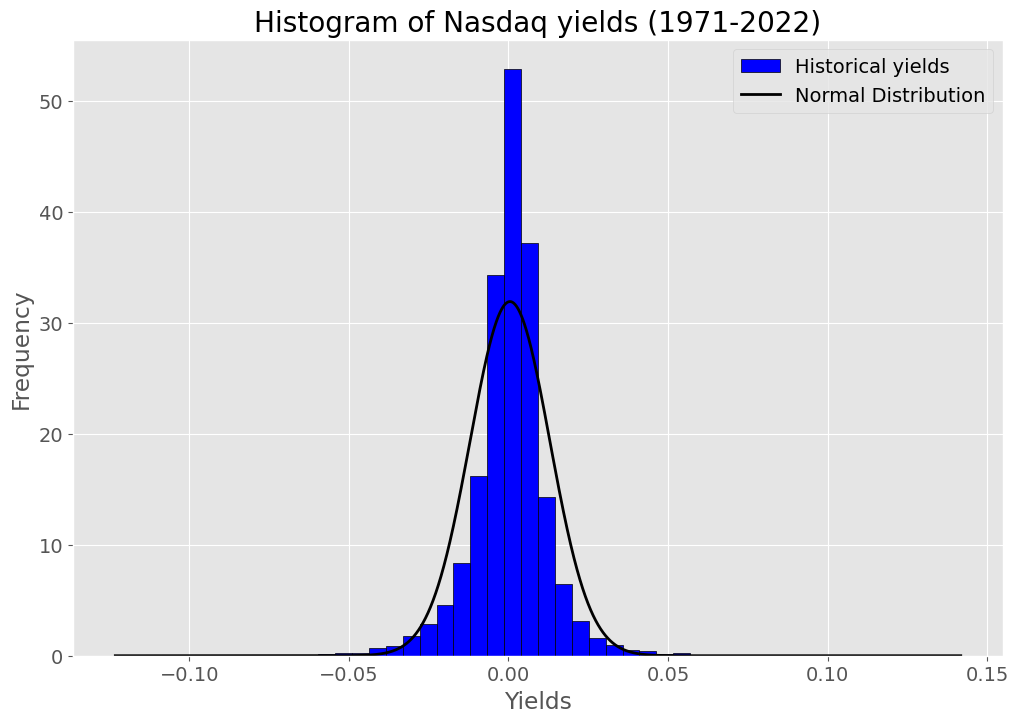

In [6]:
xmin, xmax = min(nasdaq['Daily_Return']), max(nasdaq['Daily_Return']) 
x = np.linspace(xmin, xmax, 10000)
mu, sigma = total_average_yield, volatility_total
p = norm.pdf(x, mu, sigma)
plt.hist(nasdaq['Daily_Return'], bins=50, density=True, color='blue', edgecolor='black', label='Historical yields')
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
plt.title('Histogram of Nasdaq yields (1971-2022)')
plt.xlabel('Yields')
plt.ylabel('Frequency')
plt.legend()

#Comments
"""
As we can see from the graph below, the time series of historical daily returns for the NASDAQ from 1971 to 2022 
follows approximately a normal distribution. Indeed, the density function of the time series of nasdaq returns 
looks like a centred symmetrical bell curve. However, to support our graphical analysis, 
we can calculate the degree of skewness of this time series, and if the skewness is close to 0, 
we can state that nasdaq returns from 1971 to 2022 follow a normal distribution.
We can also use the Komolgorov-Smirnov test to determine whether our time series follows a normal distribution. 
If the p-value is greater than 0.05, then we can state that the time series follows a normal distribution. 
"""

## Simple returns VS log-returns

Definissez puis expliquez, en anglais, quelles sont les différences entre rendements artithmétiques et log-rendments, quand les utiliser, ainsi que leurs avantages et inconvénients.

### Rendements arithmétiques

Arithmetic returns represent the straightforward percentage change in an investment's price over a specified period. 
This type of return metrics is the difference between the final price and the initial price of an asset, divided by the initial price.

Arithmetic_returns = (Pt - Pt-1) / Pt-1 = (Pt-1 / Pt) - 1
--> with P = Price of an asset, and t = Time

Arithmetic returns are often used to calculate average returns over a given period, such as daily, monthly or annual returns.

### Log-rendements

Logarithmic returns are calculated using the natural logarithm of the price ratio

Logarithmic returns = ln(Pt / Pt-1)
--> with P = Price of an asset, and t = Time

Logarithmic returns are particularly useful for evaluating long-term investments as they accurately reflect the compounding effect.

### Comparaison

Arithmetic returns:
    - Advantages
        --> Easy to grasp and interpret
        --> Suitable for short-term investment analysis
        --> Effective for comparing investments with identical starting and ending prices
    - Disadvantages
        --> Does not take into account the capitalisation factor, which can be misleading for long-term investments
    - When should this yield calculation method be used?
        --> Arithmetic returns are often used for discrete periods such as daily, monthly or annual returns

Logarithmic returns
    - Advantages
        --> Account for compounding, accurately reflecting long-term performance
        --> Comparing investments with different starting prices
    - Disadvantages
        --> Can be more difficult to understand and interpret
        --> Sensitive to small price changes
    - When should this yield calculation method be used?
        --> Log returns can be used to assess risk more effectively, as they incorporate the compounding effect, which can                   amplify both gains and losses over time

Arithmetic performance is simpler to use, but generates an asymmetry not present in the logarithmic method (geometric rate).
An increase followed by an identical decrease produces 2 different arithmetic arithmetic rates, whereas the geometric
opposite (change of sign).

## Modele de prediction (SVM)

Au 19 janvier 2022, le Nasdaq côte USD 14,340.25. En vous aidant de l'approche Support Vector Machine (SVM), construisez un modèle vous permettant de définir le prix du Nasdaq deux semaines (=10 jours) plus tard.

### Data

In [7]:
# Number of days ahead to predict Nasdaq price
n = 10
nasdaq_info = nasdaq.info()
number_emptyvalues = nasdaq.isnull().sum()
num_zeros_per_column = nasdaq.apply(pd.Series.value_counts).loc[0]
number_lines = nasdaq.shape[0]

print(nasdaq_info)
print("\nNumber of empty values in the dataframe: \n", number_emptyvalues)
print("\nNumber of values = 0 in the dataframe: \n", num_zeros_per_column)
print("\nNumber of lines in the Nasdaq Dataframe: ", number_lines)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12851 entries, 1971-02-08 to 2022-01-19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          12851 non-null  float64
 1   High          12851 non-null  float64
 2   Low           12851 non-null  float64
 3   Close         12851 non-null  float64
 4   Adj Close     12851 non-null  float64
 5   Volume        12851 non-null  int64  
 6   Daily_Return  12851 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.3 MB
None

Number of empty values in the dataframe: 
 Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Daily_Return    0
dtype: int64

Number of values = 0 in the dataframe: 
 Open               NaN
High               NaN
Low                NaN
Close              NaN
Adj Close          NaN
Volume          3456.0
Daily_Return      38.0
Name: 0.0, dtype: float64

Number of lines in t

In [8]:
# Delete rows that have at least one value = 0
nasdaq = nasdaq[nasdaq['Volume'] != 0]
num_zeros_per_column = nasdaq.apply(pd.Series.value_counts).loc[0]
number_lines = nasdaq.shape[0]

nasdaq 
print("\nNumber of values = 0 in the dataframe: \n", num_zeros_per_column)
print("\nNumber of lines in the Nasdaq Dataframe: ", number_lines)


Number of values = 0 in the dataframe: 
 Open             NaN
High             NaN
Low              NaN
Close            NaN
Adj Close        NaN
Volume           NaN
Daily_Return    30.0
Name: 0.0, dtype: float64

Number of lines in the Nasdaq Dataframe:  9395


In [9]:
# Description of the database
nasdaq = nasdaq.drop(columns=["Daily_Return"])
nasdaq.describe(include="all")

,Open,High,Low,Close,Adj Close,Volume
count,9395.000000,9395.000000,9395.000000,9395.000000,9395.000000,9.395000e+03
mean,2886.336767,2905.322784,2864.294626,2886.138119,2886.138119,1.418551e+09
std,3039.733205,3058.134267,3017.842476,3039.666559,3039.666559,1.168459e+09
min,238.000000,238.399994,237.699997,238.100006,238.100006,3.884000e+07
25%,739.250000,742.014984,735.984985,739.524994,739.524994,2.811800e+08
50%,2043.609985,2057.800049,2027.109985,2043.219971,2043.219971,1.601280e+09
75%,3501.680054,3537.440064,3474.214966,3503.190064,3503.190064,2.005925e+09
max,16120.919920,16212.230470,16017.230470,16057.440430,16057.440430,1.110216e+10


### SVM model

In [11]:
# Definition of X (features) and y (target)
X_features = nasdaq[["Open", "High", "Low", "Volume"]]
y_prices = nasdaq["Adj Close"]
# Division of data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_prices, test_size=0.2, random_state=42)

In [12]:
# Pipeline construction
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Vous pouvez également utiliser RobustScaler si nécessaire
    ('svm', SVR())  # Modèle SVM de régression
])
# model training
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVR())])

In [13]:
# Prédictions sur l'ensemble de test
predictions = pipeline.predict(X_test)
predictions

array([ 925.60885342, 4011.83429901,  858.74285459, ..., 2101.52734133,
        833.53833064, 1718.0704168 ])

In [14]:
# Evaluation of the model according to the regression criteria
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R2 Score: 0.31396581880531105
Mean Squared Error: 6412335.550859024
Mean Absolute Error: 1004.8976364264516


### Tuning des hyper paramètres

In [15]:
# Definition of the hyperparameter grid to optimize
param_grid = {
    'svm__kernel': ['linear', 'poly', 'rbf'],  # Different types of SVM kernels
    'svm__C': [0.1, 1, 10],  # Regularization parameter
    'svm__epsilon': [0.1, 0.01, 0.001]  # Tolerable margin of error
}

In [22]:
# Best hyperparameter search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
# Best model found
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred

array([ 701.9644429 , 6301.50834912,  493.7500809 , ..., 2082.45418558,
        380.74009519, 1870.05283009])

In [24]:
print(y_pred)
# Evaluation of the model according to the regression criteria
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

[ 701.9644429  6301.50834912  493.7500809  ... 2082.45418558  380.74009519
 1870.05283009]
Mean Squared Error: 3091.2365871018574
Mean Absolute Error: 32.100493792747706
R2 Score: 0.9996692790101062


After searching for optimal hyperparameters, we obtain an r2 of 99.96%. It is highly likely that the model is over-fit. 
In addition, in my opinion, we cannot get the price of the Nasdaq on February 2, 2022, because we do not have the characteristics related to this date. 


ValueError: X has 1 features, but MinMaxScaler is expecting 4 features as input.

Selon le modèle SVM construit, le prix du Nasdaq attendu le mercredi 2 février 2022 est de USD ..........

# Gestion de portefeuille

Le but de cette section est de mesurer votre capacité a simuler et trouver l'allocation optimale tout en controlant son risque. Le portefeuille initial est composé de 5 actions US: AMD, Cisco, Intel, Intuit et NVidia. Chacun des 5 actifs représente 20% du portefeuille. 

In [57]:
# Load locally stored data
df = pd.read_csv('nasdaqstocks.csv', index_col=0, parse_dates=True)
df

,AMD,CSCO,INTC,INTU,NVDA
Date,,,,,
2017-01-03,11.430000,25.985626,31.973003,110.028519,25.166445
2017-01-04,11.430000,25.831156,31.807022,110.249069,25.753609
2017-01-05,11.240000,25.891226,31.754606,110.929855,25.099838
2017-01-06,11.320000,25.942713,31.868174,112.381989,25.435354
2017-01-09,11.490000,25.899807,31.981735,112.045395,26.466589
...,...,...,...,...,...
2021-12-23,146.139999,61.915154,50.922092,634.972839,296.349487
2021-12-27,154.360001,63.048477,51.547329,652.013062,309.397308
2021-12-28,153.149994,63.157833,51.368690,649.026550,303.168335


In [58]:
# Attribute equal weights to each asset
numofassets = len(df.columns)
# Define Weights for Equal weighted portfolio
wts = numofassets * [1./numofassets]
# Reshape
wts = np.array(wts)[:,np.newaxis]
wts

array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2]])

## Evolution des rendements cumulés

Tracez l'évolution de la performance cumulée de chaque actif du portefeuille dans le temps.

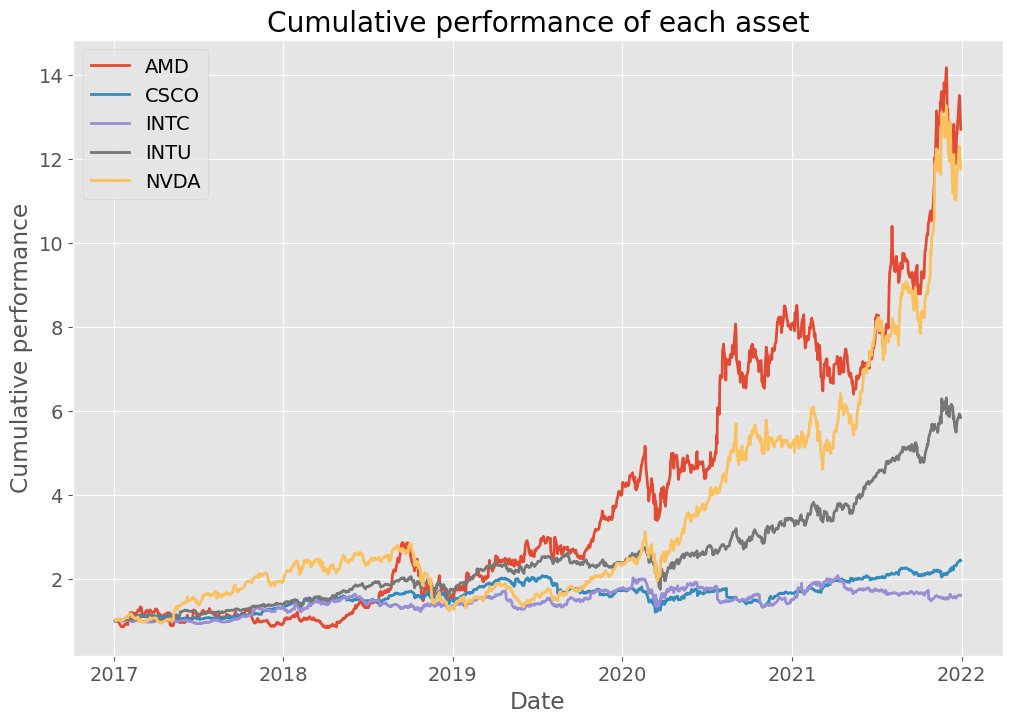

In [59]:
# Compute daily yields
daily_returns = df.pct_change()
daily_returns = daily_returns.dropna()
# Compute cumulative performance
cumulative_returns = (1 + daily_returns).cumprod()
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.title('Cumulative performance of each asset')
plt.xlabel('Date')
plt.ylabel('Cumulative performance')
plt.legend()

## Risque du portefeuille

### Hypothèse loi normale

En supposant que les rendements du portefeuille suivent une loi normale, calculez:
1. la Value-at-Risk du portefeuille à 95% et horizon 1 jour. Commentez.
2. la Conditional Value-at-Risk du portefeuille à 99% et horizon 1 mois. Commentez.

In [61]:
# Calculate portfolio parameters mu (mean), sigma (standart deviation)
portfolio_returns = np.dot(daily_returns, wts)
mu_portfolio = np.mean(portfolio_returns)
cov_matrix = np.cov(daily_returns, rowvar=False)
sigma_portfolio = np.sqrt(np.dot(wts.T, np.dot(cov_matrix, wts)))
#In this case, we will do the assumption that the returns follow a normal law
# Calculation of portfolio VaR at 95% for a 1-day horizon
VaR_95_1d = norm.ppf(0.05, mu_portfolio, sigma_portfolio) * np.sqrt(1)
# Calculation of the portfolio’s CV at 99% for a 1-month horizon
VaR_99_1m = norm.ppf(0.01, mu_portfolio, sigma_portfolio) * np.sqrt(10)
CVaR_99_1m = mu_portfolio - (sigma_portfolio * norm.pdf(norm.ppf(0.01)) / (0.01))

print("The portfolio VaR at 95% for a 1-day horizon is :", round(float(VaR_95_1d [0][0]) * 100, 2), '%')
print("The CVaR of the portfolio at 99% for a horizon of 1 month is :", round(float(CVaR_99_1m [0][0]) * 100, 2), '%')

# Comments
"""
With a confidence level of 95%, the 1-day VaR indicates that there is a 95% probability that the portfolio's one-day 
loss will not exceed -3.02%.
The 99% CVaR with a 1-month horizon provides additional information compared with VaR. 
It indicates the average severity of potential losses in extreme cases (below the VaR). 
In the case of this portfolio, the CVaR at 99% and a 1-month horizon is -5.0%, 
which means that the average expected loss conditional on the loss exceeding the 99% VaR is -5%.
"""

The portfolio VaR at 95% for a 1-day horizon is : -3.02 %
The CVaR of the portfolio at 99% for a horizon of 1 month is : -5.0 %


"\nWith a confidence level of 95%, the 1-day VaR indicates that there is a 95% probability that the portfolio's one-day \nloss will not exceed -3.02%.\nThe 99% CVaR with a 1-month horizon provides additional information compared with VaR. \nIt indicates the average severity of potential losses in extreme cases (below the VaR). \nIn the case of this portfolio, the CVaR at 99% and a 1-month horizon is -5.0%, \nwhich means that the average expected loss conditional on the loss exceeding the 99% VaR is -5%.\n"

### Hypothèse loi de Student

En supposant que les rendements du portefeuille suivent désormais une loi de Student à 5 degrés de liberté, calculez la Value-at-Risk du portefeuille à 95% et horizon 1 jour. Commentez.

In [63]:
#In this case, we will do the assumption that the returns follow a student low with a degree of freedom of 5
# Calculation of portfolio VaR at 95% for a 1-day horizon
VaR_95_1d_student = t.ppf(0.05, 5, loc=mu_portfolio, scale=sigma_portfolio) * np.sqrt(1)
print("The portfolio VaR at 95% for a 1-day horizon is :", round(float(VaR_95_1d_student [0][0]) * 100, 2), '%')

# Comments
"""
Assuming that portfolio returns follow a student's t-distribution, 
the 95% VaR at 1 day is higher than that calculated with a normal distribution. 
This means that the t-distribution is more likely to assign higher probabilities to extreme events than the normal distribution.
As a result, when using the student's t-distribution to calculate VaR, we are taking into account the possibility of 
more extreme losses than we would if we were using the normal distribution. 
This leads to a higher VaR estimate, which reflects a more pessimistic view of market risk.
"""

The portfolio VaR at 95% for a 1-day horizon is : -3.74 %


"\nAssuming that portfolio returns follow a student's t-distribution, \nthe 95% VaR at 1 day is higher than that calculated with a normal distribution. \nThis means that the t-distribution is more likely to assign higher probabilities to extreme events than the normal distribution.\nAs a result, when using the student's t-distribution to calculate VaR, we are taking into account the possibility of \nmore extreme losses than we would if we were using the normal distribution. \nThis leads to a higher VaR estimate, which reflects a more pessimistic view of market risk.\n"

### Comparaison

Augmentez désormais le nombre de degrés de liberté de la loi de Student. Qu'observez-vous?

In [64]:
for degree_freedom in range(5, 30, 1):
    VaR_95_1d_student = t.ppf(0.05, degree_freedom, loc=mu_portfolio, scale=sigma_portfolio) * np.sqrt(1)
    print("The portfolio VaR at 95% for a 1-day horizon is :", round(float(VaR_95_1d_student [0][0]) * 100, 2), '%')

The portfolio VaR at 95% for a 1-day horizon is : -3.74 %
The portfolio VaR at 95% for a 1-day horizon is : -3.6 %
The portfolio VaR at 95% for a 1-day horizon is : -3.51 %
The portfolio VaR at 95% for a 1-day horizon is : -3.44 %
The portfolio VaR at 95% for a 1-day horizon is : -3.39 %
The portfolio VaR at 95% for a 1-day horizon is : -3.35 %
The portfolio VaR at 95% for a 1-day horizon is : -3.32 %
The portfolio VaR at 95% for a 1-day horizon is : -3.29 %
The portfolio VaR at 95% for a 1-day horizon is : -3.27 %
The portfolio VaR at 95% for a 1-day horizon is : -3.25 %
The portfolio VaR at 95% for a 1-day horizon is : -3.23 %
The portfolio VaR at 95% for a 1-day horizon is : -3.22 %
The portfolio VaR at 95% for a 1-day horizon is : -3.21 %
The portfolio VaR at 95% for a 1-day horizon is : -3.2 %
The portfolio VaR at 95% for a 1-day horizon is : -3.19 %
The portfolio VaR at 95% for a 1-day horizon is : -3.18 %
The portfolio VaR at 95% for a 1-day horizon is : -3.17 %
The portfolio Va

If we increase the degree of freedom of the Student distribution, the value of the 95% 1-day VaR decreases until it tends towards the result obtained with a Normal distribution.

## Trouver l'allocation optimale par une approche Monte-Carlo

1. Implementez une simulation de Monte Carlo pour génerer des poids aléatoires pour chacun des 5 actifs en portefeuille.
2. Pour chaque allocation simulée, calculez le rendement, volatilité et ratio de Sharpe attendu du portefeuille - le taux sans risque $r_f$ est égal à 0 pour simplifier.
3. Identifiez le portefeuille avec le rendement le plus élevé par unité de risque - e.g. le portefeuille avec le ratio de Sharpe le plus élevé.
4. Commentez.

In [65]:
# Initialisation the parameters of our simulation
num_simulations = 10000 #number of simulations
rf = 0 # risk-free rate
weights_list, list_mu, list_sigma, list_sharpe_ratio = [], [], [], []
df_simulations = pd.DataFrame()

In [66]:
# Monte Carlo simulation
for i in range(num_simulations):
    # Generation of random weights for each asset
    weights = np.random.rand(numofassets)
    weights = weights / np.sum(weights)
    wts_list = weights.tolist()
    weights = weights[:,np.newaxis]
    # Mean calculation
    portfolio_returns = np.dot(daily_returns, weights)
    mu_portfolio = np.mean(portfolio_returns)
    # Volatility calculation
    cov_matrix = np.cov(daily_returns, rowvar=False)
    sigma_portfolio = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) 
    # Sharpe Ratio calculation
    sharpe_ratio = (mu_portfolio - rf) / sigma_portfolio
    # Addition of calculations to the corresponding lists
    weights_list.append(wts_list)
    list_mu.append(mu_portfolio)
    list_sigma.append(sigma_portfolio [0][0])
    list_sharpe_ratio.append(sharpe_ratio [0][0])

# Insertion of monte carlo simulation results in a dataframe
df_simulations = pd.DataFrame(weights_list, columns=daily_returns.columns)
df_simulations['Yield'] = list_mu
df_simulations['Volatility'] = list_sigma
df_simulations['Sharpe_Ratio'] = list_sharpe_ratio

df_simulations

,AMD,CSCO,INTC,INTU,NVDA,Yield,Volatility,Sharpe_Ratio
0,0.066153,0.199201,0.015841,0.312086,0.406719,0.001830,0.020372,0.089846
1,0.282663,0.108467,0.167133,0.167128,0.274608,0.001871,0.021730,0.086118
2,0.251684,0.170778,0.140799,0.211245,0.225494,0.001778,0.020448,0.086974
3,0.117269,0.135585,0.143862,0.373961,0.229323,0.001663,0.019013,0.087455
4,0.255553,0.185510,0.257671,0.178889,0.122377,0.001574,0.019461,0.080882
...,...,...,...,...,...,...,...,...
9995,0.151392,0.247862,0.254447,0.219137,0.127161,0.001425,0.018019,0.079082
9996,0.026114,0.263998,0.378616,0.307833,0.023439,0.001075,0.016784,0.064080
9997,0.108840,0.304189,0.333469,0.149902,0.103601,0.001242,0.017511,0.070934
9998,0.124539,0.306334,0.234548,0.313540,0.021040,0.001287,0.016847,0.076381


In [67]:
# find the maximum sharpe ratio
max_sharpe_ratio = df_simulations['Sharpe_Ratio'].max()
index_max_sharpe_ratio = df_simulations.loc[df_simulations['Sharpe_Ratio'] == max_sharpe_ratio].index[0]
optimal_portfolio = df_simulations.iloc[index_max_sharpe_ratio]

# Display the characteristics of the optimal portfolio
optimal_portfolio

AMD             0.233316
CSCO            0.004148
INTC            0.031968
INTU            0.565289
NVDA            0.165278
Yield           0.001940
Volatility      0.020718
Sharpe_Ratio    0.093633
Name: 5328, dtype: float64

In [68]:
list_optimal_allocation = [optimal_portfolio[df_simulations.columns[0]], optimal_portfolio[df_simulations.columns[1]],
                          optimal_portfolio[df_simulations.columns[2]], optimal_portfolio[df_simulations.columns[3]],
                          optimal_portfolio[df_simulations.columns[4]]]
list_optimal_allocation_pct = [round(x * 100, 2) for x in list_optimal_allocation]
print("Optimal allocation (asset weights) in %: ", list_optimal_allocation_pct)
print("Optimal Portfolio Expected Performance: ", round(optimal_portfolio['Yield'], 5)*100, '%')
print("Expected volatility of the optimal portfolio: ", round(optimal_portfolio['Volatility']*100, 5), '%')
print("Optimal Portfolio Expected Sharpe Ratio: ", round(optimal_portfolio['Sharpe_Ratio'], 5))

Optimal allocation (asset weights) in %:  [23.33, 0.41, 3.2, 56.53, 16.53]
Optimal Portfolio Expected Performance:  0.194 %
Expected volatility of the optimal portfolio:  2.07181 %
Optimal Portfolio Expected Sharpe Ratio:  0.09363


In [69]:
# Annualized results
annualized_mu_portfolio = (optimal_portfolio['Yield'] + 1)**252 - 1
annualized_sigma_portfolio = (optimal_portfolio['Volatility']) * (252)**0.5
annualized_sharpe_ratio = (annualized_mu_portfolio - rf) / annualized_sigma_portfolio

print("Annualized optimal portfolio expected performance: ", round(annualized_mu_portfolio*100, 2), "%")
print("Annualized expected volatility of the optimal portfolio: ", round(annualized_sigma_portfolio*100, 2), "%")
print("Annualized optimal portfolio expected sharpe ratio: ", round(annualized_sharpe_ratio, 5))

Annualized optimal portfolio expected performance:  62.97 %
Annualized expected volatility of the optimal portfolio:  32.89 %
Annualized optimal portfolio expected sharpe ratio:  1.91456


After performing a monte carlo simulation (10,000 iterations), we obtain the portfolio weights, that is, the portfolio with the maximum sharpe ratio. I annualized my results to make it more interpretable. The result is a sharpe ratio of 1.91, which is not abhorrent, and quite consistent. However, by analyzing the distribution of the weights of each asset, we find that our portfolio is mainly composed of the 'INTU' asset. This asset is the one that has performed the most over the analysis period that we have.
In addition, it is easier to build the best portfolio with historical data, than to assay to predict future prices...
Finally, our analysis is based on historical values. Past values do not predict future performance. It might be interesting to also do the same on forward pricing. 

# Macroéconomie

Le but de cette section est de vérifier vos capacités à implenter un modèle statistique classique, ainsi que votre attrait pour la macroéconomie, les marchés financiers et l'actualité.

## Prediction de l'inflation avec un modèle ARIMA

In [36]:
# Load locally stored data
us_cpi = pd.read_csv('US inflation.csv', index_col=0, parse_dates=True, sep=';')
us_cpi

,US CPI
Date,
1999-01-31,0.017
1999-02-28,0.016
1999-03-31,0.017
1999-04-30,0.023
1999-05-31,0.021
...,...
2023-10-31,0.032
2023-11-30,0.031
2023-12-31,0.034


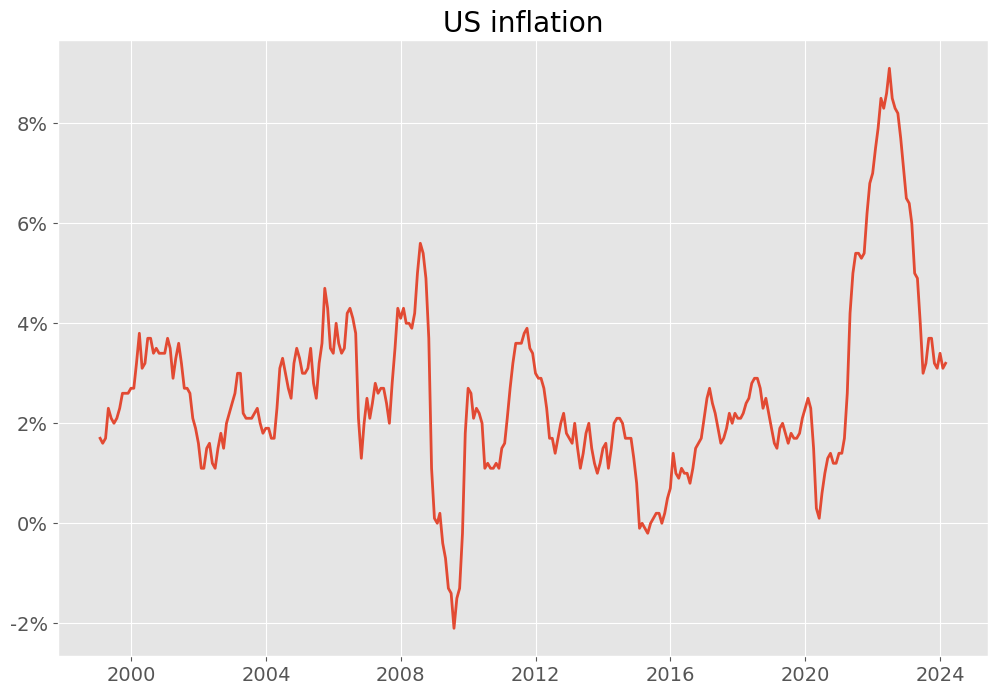

In [37]:
# Visualize the plot to verify the data
plt.plot(us_cpi.index, us_cpi['US CPI'])
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.title('US inflation');

### Stationarité

Verifiez si l'inflation est stationaire, et expliquez pourquoi la stationarité est importante dans un modèle ARIMA.

In [51]:
# Calculate the increased Dickey-Fuller test
fuller_test_results = adfuller(us_cpi)
# Extract the p-value of the augmented Dickey-Fuller test
p_value_fuller = fuller_test_results[1]
# Confidence level initialisation
# In our case, we will choose a confidence level of 95%, i.e. a critical threshold of 5%
critical_threshold = 0.05
# Comparison of the p-value of the increased dickey-fuller test to the critical threshold
if p_value_fuller > critical_threshold:
    print("P-Value: {}\nWe cannot reject hypothesis H0 'the time series has a unit root' with 95% confidence\nThe time series is therefore not stationary".format(p_value_fuller))
else:
    print("P-Value: {}\nWe can reject hypothesis H0 'the time series has a unit root' with 95% confidence\nThe time series is therefore stationary".format(p_value_fuller))

P-Value: 0.04425447628637271
We can reject hypothesis H0 'the time series has a unit root' with 95% confidence
The time series is therefore stationary


Observations:
Following the augmented dickey-fuller test, we can assume that the US inflation time series is stationary.
If a time series is stationary, this means that its mean, variance and covariance (of the i-th term and the (i + m)-th term) are not functions of time. The ARIMA model is a combination of the differentiation process (used to make a time series stationary) and the classic ARMA model. Consequently, if the time series is stationary, then the parameter d of the ARIMA(p,d,q) model is equal to 0. As a result, explaining the importance of stationarity in an ARIMA model is essentially the same as explaining the importance of stationarity in the use of an ARMA model. 
Their operation is based on the fundamental assumption that the underlying time series is stationary.
Furthermore, if a time series is not stationary, the interpretation of the parameters p (auto-regressive relationships) and q (moving average relationships) becomes problematic, as these parameters could reflect uncontrolled trends or changes in variance over time, rather than the dynamic relationships we are looking for.
Besides, the forecasts derived from the model may be unstable and biased, as they do not take account of potential changes in the statistical characteristics of the series
Thus, the ARMA model can be applied to a time series for forecasting purposes only if the series is stationary.

### Modèle ARIMA

Construisez un modèle ARIMA dans l'objectif de prédire l'inflation. Expliquez comment vous obtenez les valeurs de p, d et q.

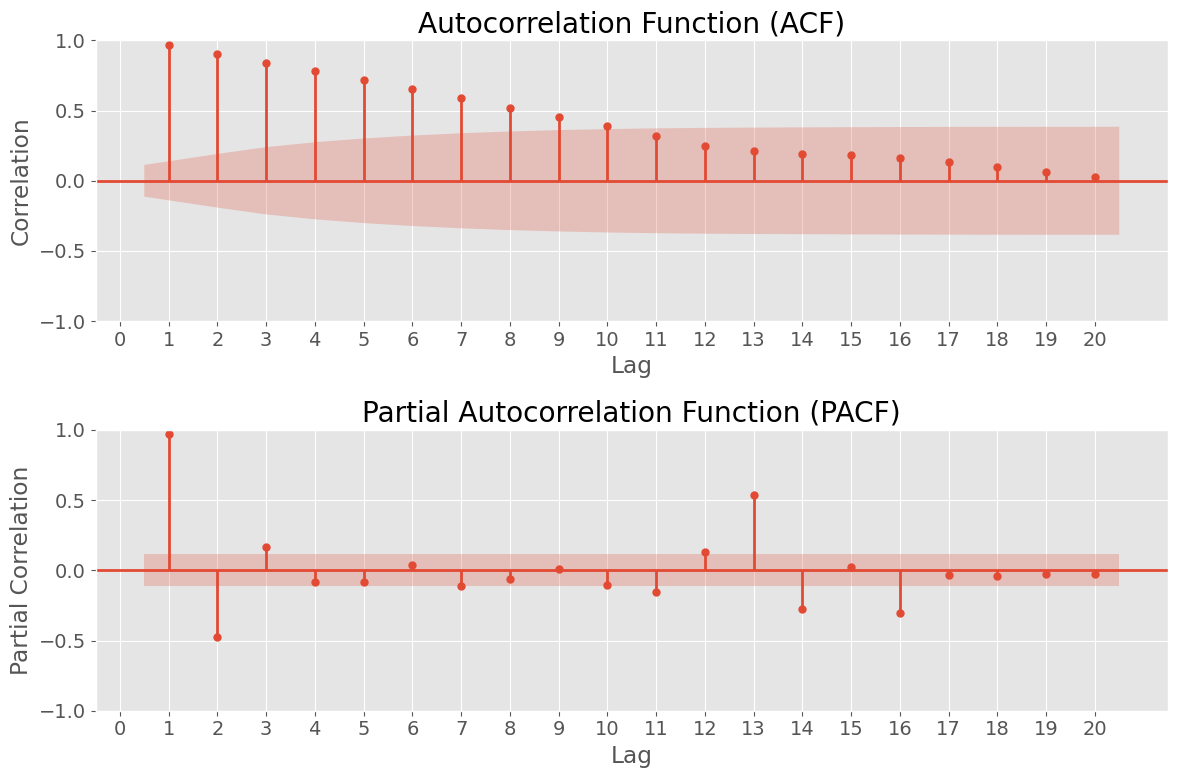

In [52]:
"""
The autocorrelation function (ACF) measures the correlation between an observation and its previous observations lagged at different times.
It is useful for identifying the number of MA (q) terms in an ARIMA. 
The partial autocorrelation function (PACF) measures the correlation between an observation and its previous observations,
taking into account the contributions of intermediate lags. 
It is useful for identifying the number of AR (p) terms in an ARIMA model
"""
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# Drawing up the ACF
plot_acf(us_cpi, lags=20, alpha=0.05, zero=False, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Correlation')
ax1.grid(True)
# Adjust the graduations on the x axis for the ACF
ax1.set_xticks(np.arange(0, 21, 1))
# Drawing up the PACF
plot_pacf(us_cpi, lags=20, alpha=0.05, zero=False, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Correlation')
ax2.grid(True)
# Adjust the graduations on the x axis for the PACF
ax2.set_xticks(np.arange(0, 21, 1))
# Adjust the subplots
plt.tight_layout()

In [53]:
# Separate data into training set and test set
train_data = us_cpi['US CPI'][:-15]
test_data = us_cpi['US CPI'][-15:]
"""
After analysing the ACF and PACF, we obtain the following parameters: AR(1) and MA(1)
"""
# Initialisation of ARIMA model parameters
p = 1
d = 0 #Because the time series is stationary
q = 1
# Construction and adjustment of the ARIMA model
ARIMA_Model = ARIMA(us_cpi, order=(p, d, q))
Results = ARIMA_Model.fit()
print(Results.summary())

                               SARIMAX Results                                
Dep. Variable:                 US CPI   No. Observations:                  302
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1232.721
Date:                Tue, 23 Apr 2024   AIC                          -2457.441
Time:                        18:49:13   BIC                          -2442.599
Sample:                    01-31-1999   HQIC                         -2451.503
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0255      0.006      4.351      0.000       0.014       0.037
ar.L1          0.9397      0.017     55.256      0.000       0.906       0.973
ma.L1          0.5030      0.039     12.865      0.0

"\nThis analysis of the model's residuals enables performance to be analysed. \nIf the ACF and PACF graphs of the residuals have many statistically significant peaks, \nthen the validity of the model may be called into question. \nIn our case, we can observe few peaks.\nIn addition, the p-value of the autoregressive factor and the moving average factor are statistically significant (p-value < 0.05).\nFinally, the AIC and BIC criteria are at an acceptable level (AIC and BIC must be minimised). \nThis supports the validity of the model. \n"

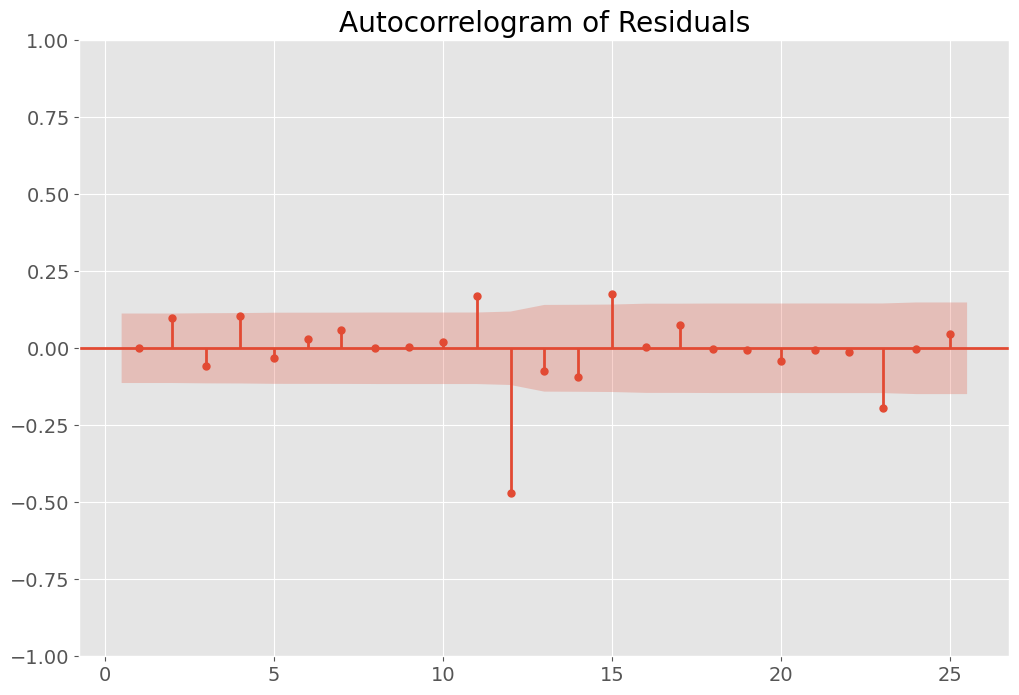

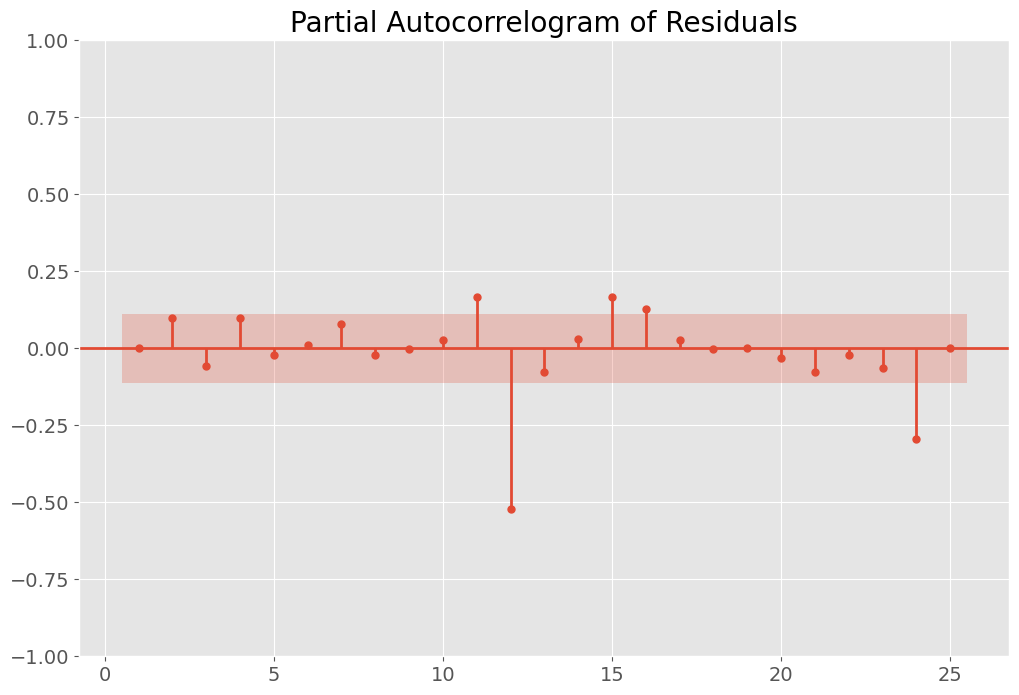

In [54]:
# Calculate residuals
residuals = Results.resid
# Drawing up the ACF of residues
plot_acf(residuals, lags=25, zero=False)
plt.title("Autocorrelogram of Residuals")
# Drawing up the PACF of residues
plot_pacf(residuals, lags=25, zero=False)
plt.title("Partial Autocorrelogram of Residuals")

# Comments
"""
This analysis of the model's residuals enables performance to be analysed. 
If the ACF and PACF graphs of the residuals have many statistically significant peaks, 
then the validity of the model may be called into question. 
In our case, we can observe few peaks.
In addition, the p-value of the autoregressive factor and the moving average factor are statistically significant (p-value < 0.05).
Finally, the AIC and BIC criteria are at an acceptable level (AIC and BIC must be minimised). 
This supports the validity of the model. 
"""

### Prediction

Sur base des prédictions de votre modèle ARIMA, quelle serait l'évolution de l'inflation sur les 12 prochains mois? Quel est le niveau d'inflation attendu au 28 février 2025?

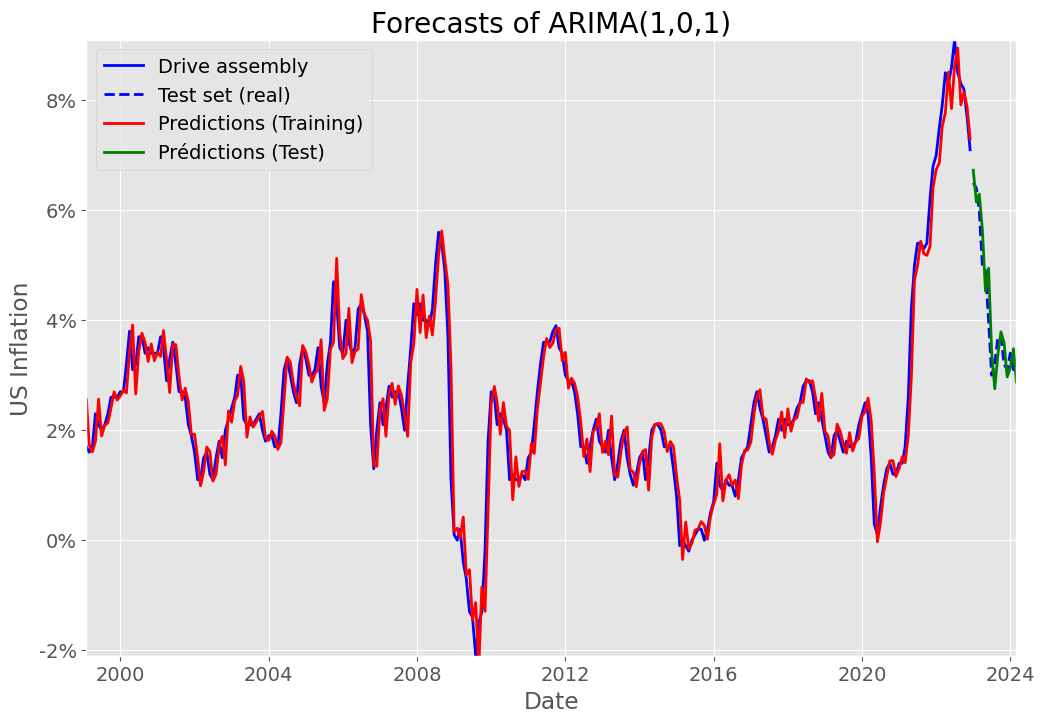

In [55]:
# Backtest on the historical data
# Training set predictions
train_predictions = Results.predict(start=train_data.index[0], end=train_data.index[-1])
# Predictions on the test set
test_predictions = Results.predict(start=test_data.index[0], end=test_data.index[-1])
# Plot predictions and actual data with pasted curves
plt.figure(figsize=(12, 8))
plt.plot(train_data.index, train_data.values, label='Drive assembly', color='blue')
plt.plot(test_data.index, test_data.values, label='Test set (real)', color='blue', linestyle='--')
plt.plot(train_predictions.index, train_predictions, label='Predictions (Training)', color='red')
plt.plot(test_predictions.index, test_predictions, label='Prédictions (Test)', color='green')
# Define the limits of the x and y axes to ensure visual continuity
plt.xlim(train_data.index[0], test_data.index[-1])
plt.ylim(min(train_data.min(), test_data.min()), max(train_data.max(), test_data.max()))
plt.xlabel('Date')
plt.ylabel('US Inflation')
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
title = 'Forecasts of ARIMA(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
plt.title(title)
plt.legend()

Forecasts for the next 12 months : 2024-03-31    0.033248
2024-04-30    0.032783
2024-05-31    0.032346
2024-06-30    0.031936
2024-07-31    0.031550
2024-08-31    0.031188
2024-09-30    0.030848
2024-10-31    0.030528
2024-11-30    0.030227
2024-12-31    0.029945
2025-01-31    0.029679
2025-02-28    0.029430
Freq: M, Name: predicted_mean, dtype: float64


Text(0, 0.5, 'US Inflation')

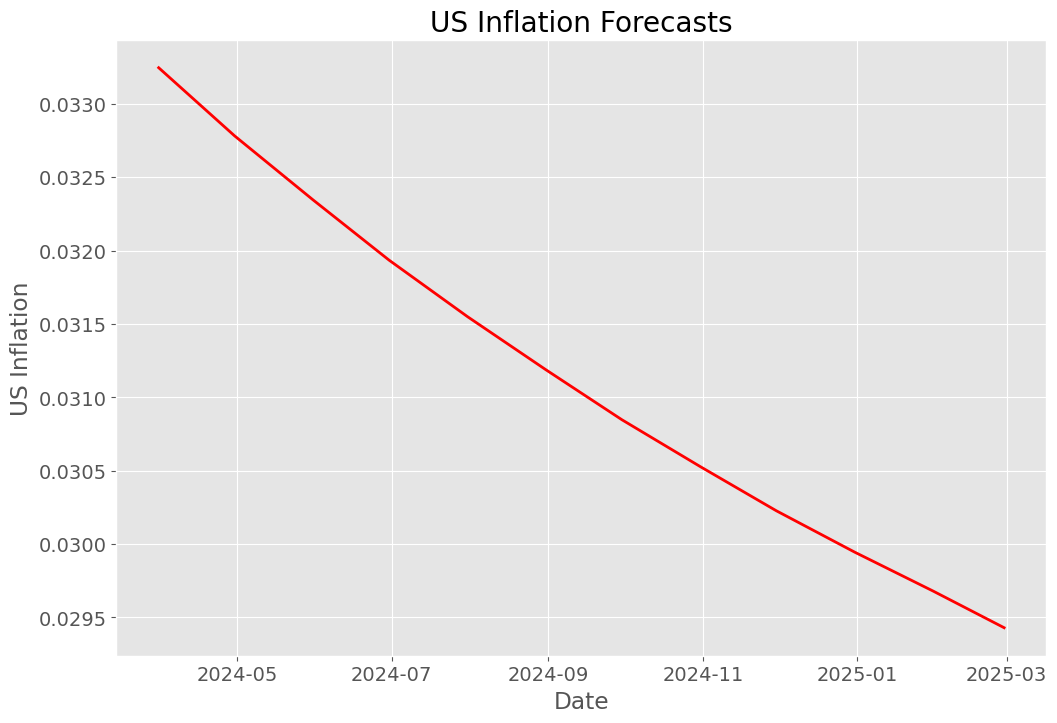

In [56]:
# Use the forecast method to obtain predictions for the next 12 months
forecast_steps = 12
forecast = Results.forecast(steps=forecast_steps)
# Print forecosts for the next 12 months
print("Forecasts for the next 12 months :", forecast)
#Visualize the plot
plt.plot(forecast, color='red', linewidth=2)
plt.title('US Inflation Forecasts')
plt.xlabel('Date')
plt.ylabel('US Inflation')

Inflation au 28 février 2025 selon modèle ARIMA: 2,94%

## Questions ouvertes

Completez ces questions en étant le plus concis possible.

1. Quel est l’effet provoqué par une injection de masse monétaire par une banque centrale ?

L'injection de masse monétaire par une banque centrale augmente la quantité de monnaie disponible au sein de l'économie d'un pays ou une zone géographique. C'est par l'intermédiaire des banques commerciales, qui "reçoivent" plus de liquidité de la part de leur banque centrale, et qui par conséquent octroient d'avantages de prêts bancaires aux ménages, entreprises et Etats, que la monnaie est injectée dans l'économie. 
Cette injection de masse monétaire engendre une stimulation des investissement et de la consommation. Cependant, suivant la situation économique de la zone géographique concernée, cela peut engendrer la dépréciation de la valeur de la monnaie nationale, et de ce fait, générer une augmentation de l'inflation. 

2. Est-il possible que des taux d’intérêts soient négatifs ?

En réalité, ce ne sont pas les taux d'intérêts qui sont négatifs, mais les taux actuariels. Il n'existe pas d'obligations à coupon facial négatif, car sinon cela signifierait que c'est l'investisseur et non l'émetteur qui paie les coupons. En pratique, les émissions se font à taux facial positif, et plus particulèrement, faiblement positif, et les flux sont actualisés avec des taux négatifs (soit avec un taux actuariel unique, ou soit aux taux ZC spécifiques à chaque maturité). De ce fait, l'ajustement se fait par les prix, car à l'émission, le prix sera supérieur au pair. 

3. Quels sont les principaux risques afférents à un portefeuille obligataire ? 

Les principaux risques afférents à un portefeuille obligataire sont les suivants:
--> Risque de taux. Si les taux augmentent, le prix des obligations à taux fixe déjà émises va diminuer. Pour se couvrir, on peut détenir dans son portefeuille des obligations à taux variable ou contracter un SWAP avant la remontée des taux (Problématique : savoir avant tout le monde que les taux vont augmenter)
--> Risque de Crédit. C'est le risque que l'émetteur ne paie pas les coupons ou ne rembourse pas à échéance (Cause : L'émetteur fait défaut)
--> Risque lié aux changements de rating de l'émetteur. Par exemple, lorsqu'une obligation IG devient HY, lors du changement de rating, cela engendre une pression vendeuse (vente forcée) sur le titre, et donc une baisse du prix de ce dernier. Ce phénomène s'explique principalement par le fait que les acteurs financiers qui traitent des IG et ceux qui traitent des HY ne traitent pas les mêmes volumes. Les acteurs financiers qui traitent des IG sont principalements des institutionnels ou des gros fonds d'investissements (traitent des gros volumes) alors les IG sont traités par des entités plus petites (traitent de plus faibles volumes)
--> Risque de liquidité. Ce risque peut être très élevé pour les obligations d'entreprises peu connues, ou échangées sur des marchés peu liquide. De plus, si l'émetteur se retrouve dans une situation complexe (mauvaise réputation, problèmes financiers...) cela peut engendre une forte diminution de l'attractivité du titre.  
--> Risque Systémique. C'est le risque qu'un événement généralisé, comme une crise financière, affecte l'ensemble du marché obligataire et entraîne une baisse généralisée des prix des obligations.
--> Risque de change.

4. Pourquoi l’inflation a-t-elle ressurgit brutalement après le Covid ? puis, en 2022 ?

Tout d'abord, la crise du Covid a engendré de forte perturbations concernant les chaînes d'approvisionnement mondiales, entraînant des pénuries de biens. A la reprise de l'activité économique, la demande en biens et services a augmenté brutalement, car les confinements mis en place aux 4 coins du monde, et les mesures économiques de soutient aux ménages et aux entreprises ont engendré une augmentation de l'épargne, et par la suite, une forte volonté des ménages à consommer (libération d'une demande refoulée), et donc une forte augmentation de la demande auprès des entreprises. 
De ce fait, avec d'un côté une pénurie des biens (faible offre), et principalement ceux produient en Asie, et de l'autre une forte demande des ménages, ce phénomène a engendré une forte hausse de l'inflation mondiale, et plus particulèrement, aux Etats-Unis et en Europe. En effet, ces 2 zones géographiques sont très dépendantes des pays asiatiques en terme de production de biens.
Ensuite, en ce qui concerne l'inflation de 2022, elle provient à la fois de la persistance de l'inflation causé par la reprise économique après la fin du Covid (spirale inflationniste), et de l'invasion de l'Ukraine par la Russie. En effet, lorsqu'une l'inflation persiste, même si celle-ci concerne certains types de biens, l'inflation se généralise car cela devient une bonne excuse pour augmenter ses prix. En ce qui concerne la guerre russio-ikrainienne, cette situation a engendré une crise de l'énergie et des denrées alimentaires, ce qui a engendré une augmentation des prix mondiaux. De plus, 2022 est marqué par la réouverture de l'économie chinoise, ce qui a entraîné une augmentation de la demande en matières premières, et donc une augmentation des prix. 

5. Quels mécanismes les banques centrales ont-elles mis en place pour tenter de contrôler l’inflation ?

Le principal outil utilisé par les banques centrales pour tenter de contrôler l'inflation est le taux directeur, qui est le taux d'intérêt auquel les banques commerciales empruntent de l'argent auprès de la banque centrale. En augmentant le taux directeur, la banque centrale a rendu les emprunts plus coûteux, ce qui à engendrer une dimunution de la consommation et l'investissement, et ainsi contribuer à réduire la demande et les pressions inflationnistes. 
De plus, les banques centrales ont fortement diminué le "Quantitative Easing". Ce processus concerne le rachat massif d'obligations privées et d'Etats par les banques centrales. Dans la pratiques, les banques centrales ne rachètent pas directement ces obligations, mais mettent en place des mécanismes permettant ces rachats massifs. 
Enfin, on peut mentionner l'outil phare de Mario Draghi avec sa citation célèbre "whatever it takes" : la communication et la persuasion. En effet, pour influencer les anticipations des agents économiques concernant l'évolution future de l'inflation, les banques ont annoncé clairement leur objectif d'inflation et les mesures qu'elles allaient mettre en place pour l'atteindre. Les banques centrales peuvent contribuer à ancrer les anticipations d'inflation et à limiter les risques de spirale inflationniste.

6. Quelles sont les grandes tendances actuelles des marchés financiers? De leur évolution à court / moyen terme ?

Les grandes tendandes actuelles des marchés financiers sont :
--> Attractivé des produits obligataires suite à la remontée des taux d'intérêts (Pour le plus grand bonheur des assureurs)
--> Les principaux indices boursiers (CAC 40, S&P 500) battent tous les records. De manière générale, les actions sont à un niveau très élevé. De plus, la volatilité des marchés boursiers est forte. 
--> Commercialisation d'ETF Bitcoin Spot
--> Attractivité du marché des matières premières (Gaz, Pétrole, Electricité, et denrées alimentaires)

Evolution à court-terme:

Selon mon opinion personnelle, ceci n'est pas une recommandation d'investissement :
    - Les taux d'intérêts devraient rester stable. De ce fait, le marché obligataire restera attractif, et donc en hausse. 
    - La volatilité des marchés boursiers devraient s'accroître suite à la persistance des conflits. 
    - L'inflation concernant les matières premières va persister.

Evolution à moyen-terme:

Selon mon opinion personnelle, ceci n'est pas une recommandation d'investissement :
    - Les taux d'intérêts devraient légèrement diminués. De ce fait, le marché obligataire devrait connaitre une légère baisse.       Cependant, les produits obligataires resteront très attractifs.
    - A moyen-terme, il semble compliqué de se prononcer sur les marchés boursiers, car la situation géo-politique mondiale           est très incertaine. 
    - Cependant, la croissance économique mondiale devrait ralentir, et l'inflation devenir plus modérée et surportable.